# Lab 1

This lab will guide you through the key concepts of CV, ML and affective computing needed for the course. This lab aims to give you all the tools you might need for the affective recognition part of the final project. Many of these tools are alternative to each other so in the final project you will have the option to choose the one that best fits your needs/expertise and/or compare among them. This lab is *entirely optional* but we **strongly recommend** you go at least through the filled parts. The solution to the exercises will be provided after the last help session.


Suggested reading structure:
* Full (recommended): begin from the top and go to the bottom. You can skip parts you are already familiar with.
* Essential: jump to S1.3, continue until the end of S1.4; jump to S2.1.

# S1: Image processing 

## Imports and utilities
Here, we do the imports for S1. We also apply some patches to OpenFace to fix some issues and improve usability for the lab.

In [1]:
import imageio.v3 as iio
import cv2
from matplotlib import pyplot as plt
from IPython.display import Image, Video
from openface.face_detection import FaceDetector

# The next block fixes a bug that causes crashes on Unix-based systems.
# You should apply this patch before importing "LandmarkDetector" from openface.

# --- begin of patch ---
# Patching LandmarkDetector hardcoded log folder
from openface.STAR.demo import Alignment

# Access the utility module through Alignment.__init__'s globals
utility = Alignment.__init__.__globals__['utility']

# Only patch once to avoid recursion
if getattr(utility.set_environment, '__name__', '') != 'patched_set_environment':
    original_set_environment = utility.set_environment

    def patched_set_environment(config):
        result = original_set_environment(config)
        config.log_dir = '.'
        return result

    utility.set_environment = patched_set_environment
# --- end of patch ---

from openface.landmark_detection import LandmarkDetector
from openface.multitask_model import MultitaskPredictor
import torch.nn.functional as F
import torch
import numpy as np
from typing import Union
import os


# The next patch overrides a function in FaceDetector which expects a filename as input to also accept numpy arrays
# This will be useful later when we want to pass webcam frames directly without saving to disk

# --- begin of patch ---
def override_preprocess_image(self, image_path: Union[str, np.ndarray], resize: float = 1.0):
    if isinstance(image_path, (str, os.PathLike)):
        img_raw = cv2.imread(str(image_path), cv2.IMREAD_COLOR)  # BGR, 3 channels
        if img_raw is None:
            raise ValueError(f"Failed to read image from path: {image_path}")
    elif isinstance(image_path, np.ndarray):
        img_raw = image_path
    else:
        raise TypeError("image_path must be a str/Path-like path or a numpy.ndarray (BGR frame).")

    if img_raw.ndim == 2:
        # Grayscale -> BGR
        img_raw = cv2.cvtColor(img_raw, cv2.COLOR_GRAY2BGR)
    elif img_raw.ndim == 3:
        if img_raw.shape[2] == 4:
            # BGRA -> BGR
            img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGRA2BGR)
        elif img_raw.shape[2] != 3:
            raise ValueError(f"Unsupported channel count: {img_raw.shape[2]} (expected 1, 3, or 4)")
    else:
        raise ValueError(f"Unsupported image shape {img_raw.shape}; expected HxW or HxWxC.")

    # --- Preprocess as in original code
    img = img_raw.astype(np.float32, copy=False)
    if resize != 1.0:
        img = cv2.resize(img, None, fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)

    # Mean subtraction in BGR (matching many Caffe-style models)
    img -= (104.0, 117.0, 123.0)

    # Ensure contiguous before transpose (safer with slices or unusual strides)
    img = np.ascontiguousarray(img.transpose(2, 0, 1))  # (C, H, W)

    img = torch.from_numpy(img).unsqueeze(0).to(self.device)  # (1, C, H, W)

    return img, img_raw

FaceDetector.preprocess_image = override_preprocess_image
# --- end of patch ---

c:\Users\Daan\Projects\uu-intelligent-interactive-systems-25-26\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## S1.1: Image Manipulation

We can load images as `ndarray`s shaped `(height, width, channels)` using `iio.imread()`, and display them with `plt.imshow()`.

(numpy.ndarray, (720, 1280, 3))

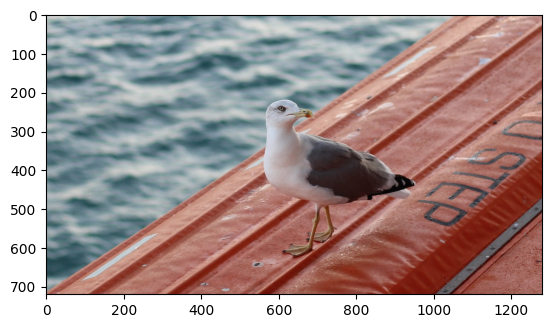

In [2]:
seagull = iio.imread("seagull.jpg") # Copyright Yuqiong Wang, 2023. Used with permission from the author.
plt.imshow(seagull)
type(seagull), seagull.shape

Typically, the type is `uint8`: integers in range 0 ... 255.

In [3]:
seagull.dtype, seagull.min(), seagull.mean(), seagull.max()

(dtype('uint8'), 0, 133.28318431712964, 255)

Since the picture is represented as an array, we can easily manipulate it. E.g., we can use *index slicing* to crop it:

(450, 450, 3)

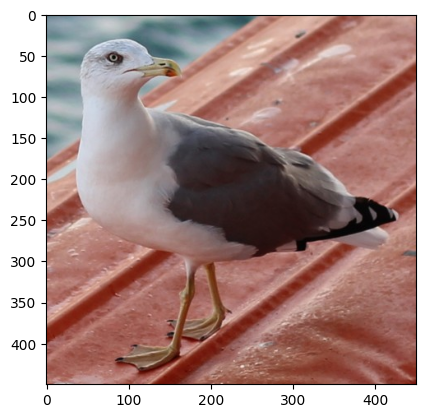

In [4]:
cutout = seagull[190:640, 525:975]
plt.imshow(cutout)
cutout.shape

If we do an extreme crop, we can see the individual pixels that form the image. In RGB, each pixel is represented by 3 values: Red, Green, and Blue intensities.

(25, 25, 3)

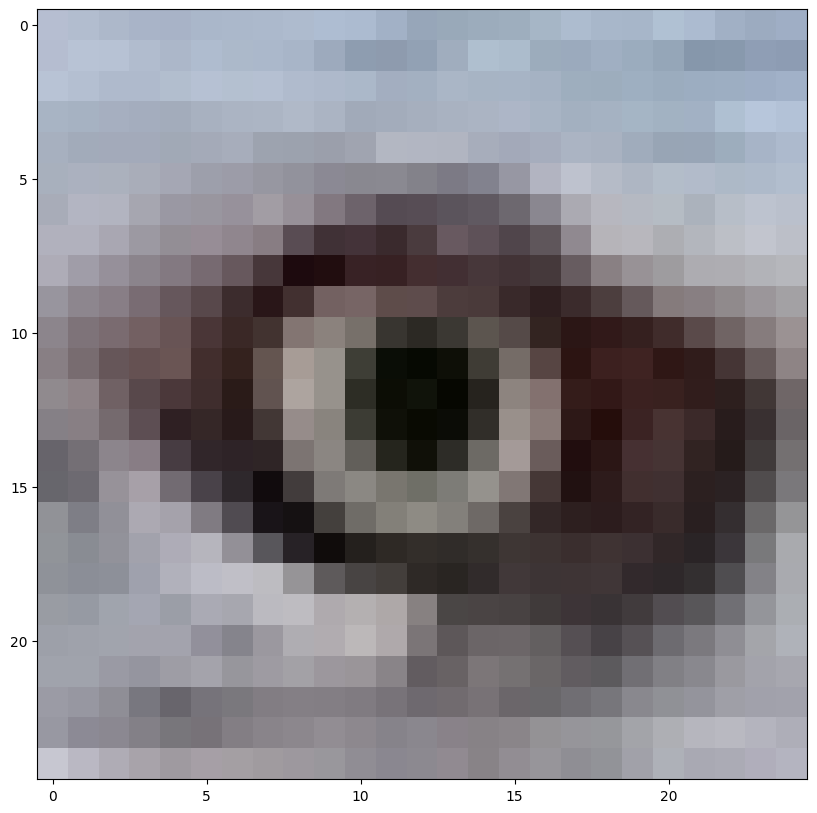

In [5]:
extreme_cutout = seagull[230:255, 595:620]
fig = plt.figure(figsize=(10,10))
plt.imshow(extreme_cutout)
extreme_cutout.shape

To show that our array stores the colors as RGB, let's set R to zero:

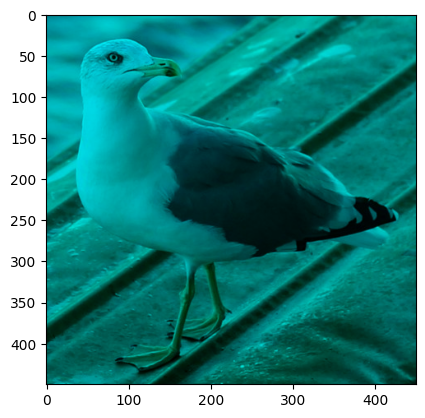

In [6]:
no_red = cutout.copy()
no_red[:, :, 0] = 0
plt.imshow(no_red)

Similarly, we can invert colors with some math:

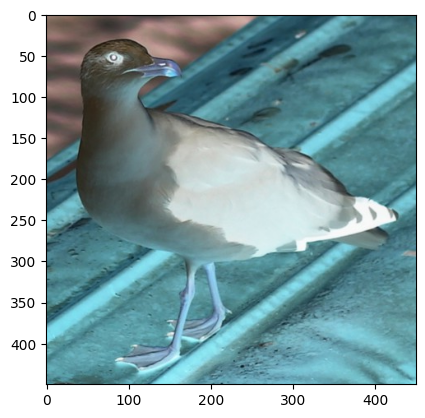

In [7]:
inverse = 255 - cutout
plt.imshow(inverse)

`iio.imwrite()` allows us to save the image to a variety of formats. In this case, `JPG`:

In [8]:
iio.imwrite("inverse.jpg", inverse)

Let's load a PNG with transparency now. In this case, the channels are `RGBA`: Red, Green, Blue, Alpha.
* `A = 0` means fully transparent
* `A = 255` means fully opaque.

(333, 333, 4)

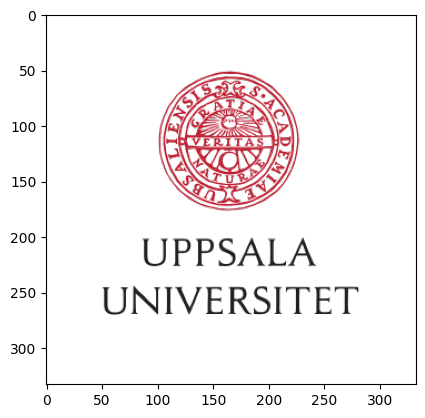

In [9]:
uu_logo = iio.imread("uu_logo.png") # Trademark owned by Uppsala University.
plt.imshow(uu_logo)
uu_logo.shape

Since PyPlot adds a white background, it's not so obvious that we have transparency. Let's make everything fully opaque to reveal the hidden RGB colors:

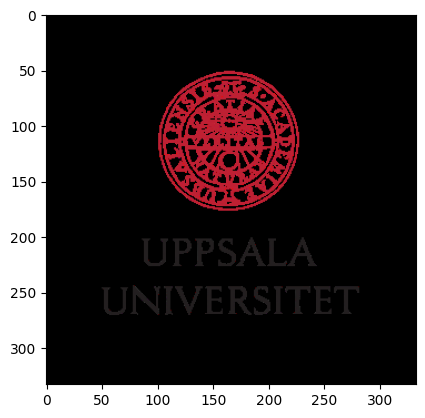

In [10]:
full_alpha = uu_logo.copy()
full_alpha[:, :, 3] = 255
plt.imshow(full_alpha)

If you get tired of the PyPlot numbers, in a Jupyter notebook you can use `IPython.display.Image`. It even respects transparency.

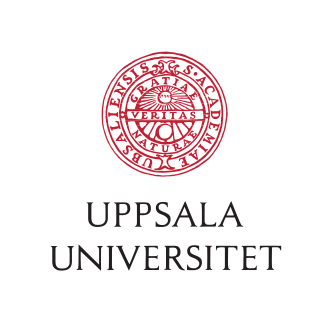

In [11]:
Image("uu_logo.png")

## S1.2: Video Manipulation

There is no good way to display videos using PyPlot, but we can use `IPython.display.Video` to embed a video in a notebook:

In [12]:
Video("cats.mp4")

The same command `iio.imread()` we used for images can also be used for videos. In this case, the array is shaped `(frames, height, width, channels)`.

In [13]:
# "cats": copyright Marc Fraile, 2023.
cats = iio.imread("cats.mp4")
cats.shape

(236, 720, 720, 3)

Loading the video as a sequence of frames discards some important information, like the framerate. We can recover this information (and other *metadata*) using `iio.immeta()`:

In [14]:
cats_meta = iio.immeta("cats.mp4")
cats_meta

{'plugin': 'ffmpeg',
 'nframes': inf,
 'ffmpeg_version': '7.1-essentials_build-www.gyan.dev built with gcc 14.2.0 (Rev1, Built by MSYS2 project)',
 'codec': 'h264',
 'pix_fmt': 'yuv420p(progressive)',
 'fps': 29.58,
 'source_size': (720, 720),
 'size': (720, 720),
 'rotate': 0,
 'duration': 7.98}

Of course, we can display individual frames just like we display images:

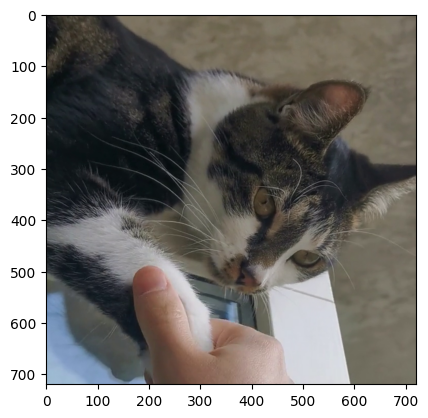

In [15]:
plt.imshow(cats[200])

## Exercises

In this first block, we will practice one of the oldest and simplest tricks in Image Analysis: **color thresholding**. We will try to isolate a brightly colored object in an image by checking color values.

Exercise 1 below: Load file "toy_knife.jpg", find color thresholds to isolate some objects, for example a toy or a hand. 
Exercise 2 below: Same as Exercise 1, but try to do this in HSV image representation. 

### Hints

* `np.zeros_like(image, shape=...)`
* You can use comparisons to index into an `ndarray`.
* You can copy most code from Exercise 1 into Exercise 2.
* `cv2.cvtColor()`
* `cv2` also has loading and saving functions `cv2.imread()` and `cv2.imwrite()`, but they expect BGR and don't work with videos.
* Use the internet!

In [ ]:
# Exercise 1
# ---------------------------------------------------------------- #
# (1) Load "toy_knife.jpg"
# (2) Make a copy that has half the values of the original.

# Your code here:

# ---------------------------------------------------------------- #

cv2.namedWindow("Color Picker (Esc to Exit)")

min_values = [ 0, 0, 0 ]
max_values = [ 255, 255, 255 ]

def check_trackbar():
    min_values[0] = cv2.getTrackbarPos("R min", "Color Picker (Esc to Exit)")
    max_values[0] = cv2.getTrackbarPos("R max", "Color Picker (Esc to Exit)")
    min_values[1] = cv2.getTrackbarPos("G min", "Color Picker (Esc to Exit)")
    max_values[1] = cv2.getTrackbarPos("G max", "Color Picker (Esc to Exit)")
    min_values[2] = cv2.getTrackbarPos("B min", "Color Picker (Esc to Exit)")
    max_values[2] = cv2.getTrackbarPos("B max", "Color Picker (Esc to Exit)")

cv2.createTrackbar("R min", "Color Picker (Esc to Exit)",   0, 255, lambda x: None)
cv2.createTrackbar("R max", "Color Picker (Esc to Exit)", 255, 255, lambda x: None)
cv2.createTrackbar("G min", "Color Picker (Esc to Exit)",   0, 255, lambda x: None)
cv2.createTrackbar("G max", "Color Picker (Esc to Exit)", 255, 255, lambda x: None)
cv2.createTrackbar("B min", "Color Picker (Esc to Exit)",   0, 255, lambda x: None)
cv2.createTrackbar("B max", "Color Picker (Esc to Exit)", 255, 255, lambda x: None)

while True:
    # ---------------------------------------------------------------- #
    # (3) Create an image that is twice as wide as the original.
    #     The left side must contain the pixels from the original image,
    #     and the right pixels must contain the pixels from the half-intensity image.
    # (4) "Mask" the wide image you just created:
    #      For each pixel, check if it's within the expected range (min_R <= R <= max_R, etc.),
    #      and set it to 0 if it's OUTSIDE the range.
    # (5) Display the masked image in the CV2 window "Color Picker".
    
    # Your code here:

    # ---------------------------------------------------------------- #

    key = cv2.waitKey(1) & 0xFF
    if key == 27: # ESC pressed
        break

# ---------------------------------------------------------------- #
# (6) Save the masked image to "masked_rgb.jpg".
# (7) Print the `min_values` and `max_values`.

# Your code here:

# ---------------------------------------------------------------- #


In [ ]:
# Exercise 2
# ---------------------------------------------------------------- #
# (1) Load "toy_knife.jpg"
# (2) Make a copy that has half the values of the original.

# Your code here:

# ---------------------------------------------------------------- #

cv2.namedWindow("Color Picker (Esc to Exit)")

min_values = [ 0, 0, 0 ]
max_values = [ 255, 255, 255 ]

def check_trackbar():
    min_values[0] = cv2.getTrackbarPos("H min", "Color Picker (Esc to Exit)")
    max_values[0] = cv2.getTrackbarPos("H max", "Color Picker (Esc to Exit)")
    min_values[1] = cv2.getTrackbarPos("S min", "Color Picker (Esc to Exit)")
    max_values[1] = cv2.getTrackbarPos("S max", "Color Picker (Esc to Exit)")
    min_values[2] = cv2.getTrackbarPos("V min", "Color Picker (Esc to Exit)")
    max_values[2] = cv2.getTrackbarPos("V max", "Color Picker (Esc to Exit)")

cv2.createTrackbar("H min", "Color Picker (Esc to Exit)",   0, 255, lambda x: None)
cv2.createTrackbar("H max", "Color Picker (Esc to Exit)", 255, 255, lambda x: None)
cv2.createTrackbar("S min", "Color Picker (Esc to Exit)",   0, 255, lambda x: None)
cv2.createTrackbar("S max", "Color Picker (Esc to Exit)", 255, 255, lambda x: None)
cv2.createTrackbar("V min", "Color Picker (Esc to Exit)",   0, 255, lambda x: None)
cv2.createTrackbar("V max", "Color Picker (Esc to Exit)", 255, 255, lambda x: None)


while True:
    # ---------------------------------------------------------------- #
    # (3) Create an image that is twice as wide as the original.
    #     The left side must contain the pixels from the original image,
    #     and the right pixels must contain the pixels from the half-intensity image.
    # (4) Convert the wide image to HSV using OpenCV.
    # (5) Mask the wide image like you did in the RGB exercise,
    # BUT this time use the HSV values for masking.
    # (6) Display the masked image in the CV2 window "Color Picker".
    
    # Your code here:

    # ---------------------------------------------------------------- #

    key = cv2.waitKey(1) & 0xFF
    if key == 27: # ESC pressed
        break

# ---------------------------------------------------------------- #
# (7) Save the masked image to "masked_rgb.jpg".
# (8) Print the `min_values` and `max_values`.

# Your code here:

# ---------------------------------------------------------------- #

## S1.3: Webcam Access

If you look up online how to do any image processing task in Python, you will be told to use [OpenCV](https://opencv.org/). This is an old C++ library with a clunky Python interface, and has plenty of downsides, but it's hard to beat it in number of features or speed of execution.

We will use OpenCV for real-time webcam access. To smooth over its usage in notebooks, we will also use `opencv_jupyter_ui`.

We have written an utility to take snapshots and another to take videos using OpenCV. You can find the code in the module `camera_widget`. Let's test them out, starting with the picture-taking app:

In [17]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

try:
    while True:
        ok, frame = cap.read()
        if not ok:
            print("Camera read failed.")
            break

        cv2.imshow("Camera", frame)

        # Wait 1 ms and check for ESC (27)
        if cv2.waitKey(1) == 27:
            break

finally:
    cap.release()
    cv2.destroyAllWindows()
    print("Stopped.")

Stopped.


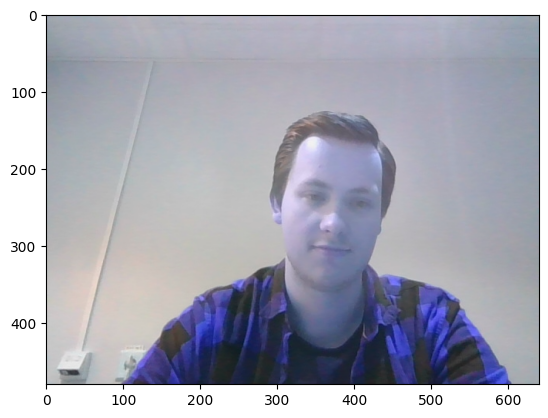

In [18]:
plt.imshow(frame)

And let's check the video-taking solution next:

In [19]:
def cv2_write_text(img: np.ndarray, text: str, position: tuple[int, int],
                   color: tuple[int, int, int] = (255, 255, 255)) -> None:
    """Write text with a black outline for readability."""
    cv2.putText(img, text, position, cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 0), 6, cv2.LINE_AA)
    cv2.putText(img, text, position, cv2.FONT_HERSHEY_PLAIN, 2, color, 2, cv2.LINE_AA)

def cv2_vid() -> tuple[float, np.ndarray]:
    """
    Webcam capture using native OpenCV window.
    Controls:
      - SPACE: start/stop recording
      - ESC:   exit
    Returns: (fps, video) where video is RGB np.ndarray with shape (T, H, W, 3)
             or an empty 0-d array if nothing recorded.
    """
    cam = cv2.VideoCapture(0, cv2.CAP_DSHOW)  # CAP_DSHOW helps on Windows
    if not cam.isOpened():
        raise RuntimeError("Could not open default camera (index 0).")

    fps = cam.get(cv2.CAP_PROP_FPS) or 0.0

    video: list[np.ndarray] = []
    playback_idx = 0
    last_recording = False
    recording = False

    try:
        while True:
            ok, frame = cam.read()
            if not ok:
                raise RuntimeError("OpenCV failed to read a frame.")

            h, w, c = frame.shape
            display = np.zeros((h, w * 2, c), dtype=frame.dtype)
            display[:, :w, :] = frame

            if video:
                playback_idx = (playback_idx + 1) % len(video)
                display[:, w:, :] = video[playback_idx]
            else:
                cv2_write_text(display, "No playback yet", (int(1.05 * w), int(0.1 * h)), (200, 200, 200))

            if recording:
                if not last_recording:
                    video = []  # start a fresh take on first frame after toggling on
                cv2_write_text(display, "RECORDING. Press SPACE to stop.",
                               (int(1.05 * w), int(0.8 * h)), (127, 127, 255))
                video.append(frame.copy())
            else:
                cv2_write_text(display, "STOPPED. Press SPACE to start.",
                               (int(1.05 * w), int(0.8 * h)), (127, 127, 127))

            cv2_write_text(display, "Press ESC to exit", (int(1.05 * w), int(0.9 * h)))

            cv2.imshow("vid", display)
            key = cv2.waitKey(1) & 0xFF
            if key == 27:       # ESC
                break
            elif key == 32:     # SPACE
                recording = not recording

            last_recording = recording
    finally:
        cam.release()
        cv2.destroyAllWindows()

    # Convert to RGB for downstream use
    if not video:
        converted = np.empty(shape=(), dtype=np.uint8)
    else:
        converted = np.stack([cv2.cvtColor(f, cv2.COLOR_BGR2RGB) for f in video], axis=0)

    return float(fps), converted

In [20]:
fps, vid = cv2_vid()
fps, vid.shape

(0.0, (110, 480, 640, 3))

To display the video, let's save it to a local file first:

In [21]:
iio.imwrite("webcam_video.mp4", vid, fps=fps)
Video("webcam_video.mp4")

We can get creative and output the channels separately. Note that OpenCV does not follow the standard RGB convention, using BGR instead.

In [22]:
cam = cv2.VideoCapture(0, cv2.CAP_DSHOW)  # CAP_DSHOW helps on Windows startup

if not cam.isOpened():
    raise RuntimeError("Could not open default camera (index 0).")

while True:
    ok, in_frame = cam.read()
    if not ok:
        break

    h, w, c = in_frame.shape
    out_frame = np.zeros((h * 2, w * 2, c), dtype=np.uint8)

    # Top-left: original image
    out_frame[:h, :w, :] = in_frame

    # Top-right: red channel only
    out_frame[:h, w:, 0] = in_frame[:, :, 0]

    # Bottom-left: green channel only
    out_frame[h:, :w, 1] = in_frame[:, :, 1]

    # Bottom-right: blue channel only
    out_frame[h:, w:, 2] = in_frame[:, :, 2]

    cv2.imshow("Video (ESC to exit)", out_frame)

    # ESC key closes
    if cv2.waitKey(10) & 0xFF == 27:
        break

cam.release()
cv2.destroyAllWindows()

## S1.4: Feature Extraction

In this course, we are interested in features related to the expression of emotion. We will focus in facial features: the position of the face, the activation of different muscles used to express emotion, or even the expressed emotion itself. OpenFace is a modern Python library that allows us to easily find facial landmarks locations. Using this locations, one may derive emotions analytically (for example to see of mouth corners are above mouth center if a person smiles) or use some kind of machnie learning algorithms to detect human emotions. 

Let's load a detector and test it on the faces of the TAs.

Note that the detector packages several models with different functions: finding faces in a picture, detecting key points (landmarks) in each face, deducing facial muscle activations (AUs), detecting emotion...

We can pass a filename to `detector.detect_image()`:

Loading pretrained model from ./weights/Alignment_RetinaFace.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300


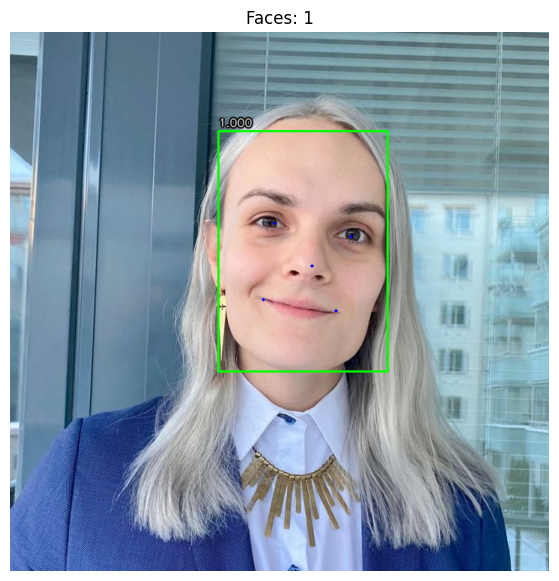

Bounding boxes [x1,y1,x2,y2]: [(278, 132, 504, 453)]
Face 1: {'score': 0.9999433755874634, 'landmarks_5': [[353.2341003417969, 255.5999755859375], [455.71697998046875, 273.426025390625], [403.19879150390625, 312.37060546875], [338.61859130859375, 357.3704833984375], [435.6676025390625, 372.5392150878906]]}


In [23]:
image_path = "lux.jpg"
device = "cuda"  # or "cuda" to make it run faster if you have a compatible GPU; you can also try "mps" on MacOS with Apple Silicon

detector = FaceDetector(model_path="./weights/Alignment_RetinaFace.pth", device=device)

# Run detection (the API returns (img, detections)); we only need detections
_, dets = detector.get_face(image_path)
if len(dets)==0:
    print("No faces detected.")
else:
    img_bgr = cv2.imread(image_path)
    h, w = img_bgr.shape[:2]
    vis = img_bgr.copy()

    boxes = []
    for i, det in enumerate(dets):
        # Expected RetinaFace-style: [x1,y1,x2,y2,score, lmk(10)?]
        x1, y1, x2, y2 = map(int, det[:4])
        score = float(det[4]) if len(det) > 4 else None
        boxes.append((x1, y1, x2, y2))

        # draw box
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0,255,0), 2)

        # draw 5 landmarks if present
        if len(det) >= 15:
            lm = det[5:15].reshape(-1,2)
            for (lx, ly) in lm.astype(int):
                cv2.circle(vis, (lx, ly), 2, (255,0,0), -1)

        # label with confidence
        if score is not None:
            cv2.putText(vis, f"{score:.3f}", (x1, max(0,y1-6)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 3, cv2.LINE_AA)
            cv2.putText(vis, f"{score:.3f}", (x1, max(0,y1-6)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

    # Show in notebook (RGB)
    plt.figure(figsize=(10,7))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Faces: {len(dets)}")
    plt.show()

    # Print details
    print("Bounding boxes [x1,y1,x2,y2]:", boxes)
    for i, det in enumerate(dets):
        info = {"score": float(det[4]) if len(det) > 4 else None}
        if len(det) >= 15:
            info["landmarks_5"] = det[5:15].reshape(-1,2).tolist()
        print(f"Face {i+1}:", info)

We can see that FaceDetector.get_face() returns not only face location, but also can find multiple facial landmarks.

What about Alessio?

Loading pretrained model from ./weights/Alignment_RetinaFace.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300


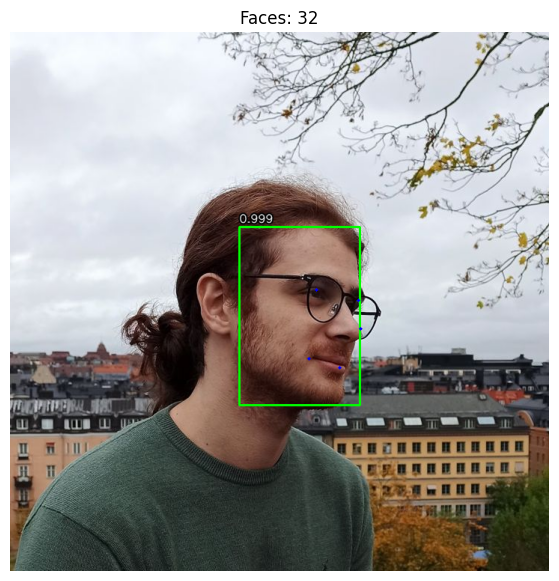

Bounding boxes [x1,y1,x2,y2]: [(306, 260, 467, 498)]
Face 1: {'score': 0.9990279674530029, 'landmarks_5': [[409.7183837890625, 344.5647277832031], [465.7920837402344, 358.3688659667969], [468.52294921875, 396.259765625], [399.230712890625, 436.6971740722656], [440.6404113769531, 448.6240539550781]]}
Face 2: {'score': 0.18800167739391327, 'landmarks_5': [[174.2340545654297, 444.6267395019531], [171.60482788085938, 447.3997497558594], [165.1222381591797, 457.07489013671875], [178.02401733398438, 462.7041931152344], [175.3379669189453, 464.41705322265625]]}
Face 3: {'score': 0.16611531376838684, 'landmarks_5': [[666.6759033203125, 483.6343078613281], [673.1414184570312, 484.1241455078125], [669.6329345703125, 487.28350830078125], [666.5474243164062, 490.2762145996094], [671.6290893554688, 490.5783996582031]]}
Face 4: {'score': 0.11448106914758682, 'landmarks_5': [[613.764892578125, 472.16400146484375], [619.5955810546875, 472.3233642578125], [616.1658325195312, 475.3023376464844], [613.91

In [26]:
image_path = "alessio.jpg"
device = "cuda"  # or "cuda" to make it run faster if you have a compatible GPU; you can also try "mps" on MacOS with Apple Silicon

detector = FaceDetector(model_path="./weights/Alignment_RetinaFace.pth", device=device)

# Run detection (the API returns (img, detections)); we only need detections
_, dets = detector.get_face(image_path)
if len(dets)==0:
    print("No faces detected.")
else:
    img_bgr = cv2.imread(image_path)
    h, w = img_bgr.shape[:2]
    vis = img_bgr.copy()

    boxes = []
    for i, det in enumerate(dets):
        # Expected RetinaFace-style: [x1,y1,x2,y2,score, lmk(10)?]
        x1, y1, x2, y2 = map(int, det[:4])
        score = float(det[4]) if len(det) > 4 else None
        
        if score <= 0.2:
            continue
        
        boxes.append((x1, y1, x2, y2))

        # draw box
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0,255,0), 2)

        # draw 5 landmarks if present
        if len(det) >= 15:
            lm = det[5:15].reshape(-1,2)
            for (lx, ly) in lm.astype(int):
                cv2.circle(vis, (lx, ly), 2, (255,0,0), -1)

        # label with confidence
        if score is not None:
            cv2.putText(vis, f"{score:.3f}", (x1, max(0,y1-6)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 3, cv2.LINE_AA)
            cv2.putText(vis, f"{score:.3f}", (x1, max(0,y1-6)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

    # Show in notebook (RGB)
    plt.figure(figsize=(10,7))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Faces: {len(dets)}")
    plt.show()

    # Print details
    print("Bounding boxes [x1,y1,x2,y2]:", boxes)
    for i, det in enumerate(dets):
        info = {"score": float(det[4]) if len(det) > 4 else None}
        if len(det) >= 15:
            info["landmarks_5"] = det[5:15].reshape(-1,2).tolist()
        print(f"Face {i+1}:", info)

Note that in this case the detector found multiple "false positives" in the background, but all of them have much lower confidence scores.

Lets try to detect all available landmarks on a cropped face:

Loading pretrained model from ./weights/Alignment_RetinaFace.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
Namespace(config_name='alignment', device_id='cuda:0')


c:\Users\Daan\Projects\uu-intelligent-interactive-systems-25-26\env\Lib\site-packages\torch\__init__.py:1275: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)


Processing face: (232, 96, 394, 315), confidence: 0.9974682331085205


c:\Users\Daan\Projects\uu-intelligent-interactive-systems-25-26\env\Lib\site-packages\torch\functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


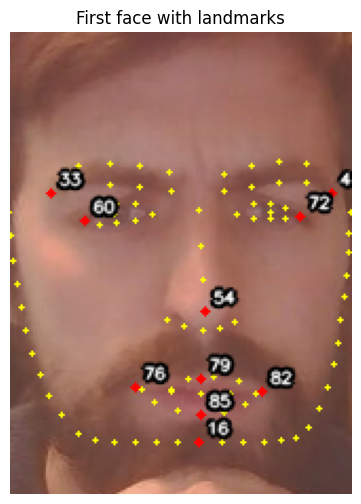

In [27]:
img_path = "marc.jpg"
device = "cuda"  # or "cuda"

import logging
logging.disable(logging.INFO)

# --- 1) detect first face
det = FaceDetector("./weights/Alignment_RetinaFace.pth", device=device)
crop_face, dets = det.get_face(img_path)
if len(dets)==0:
    raise SystemExit("No faces detected.")


img_bgr = cv2.imread(img_path); h, w = img_bgr.shape[:2]
x1,y1,x2,y2 = map(int, dets[0][:4]); x1,y1=max(0,x1),max(0,y1); x2,y2=min(w-1,x2),min(h-1,y2)
crop = img_bgr[y1:y2, x1:x2].copy()

# --- landmarks 

lmk = LandmarkDetector("./weights/Landmark_98.pkl", device=device, device_ids=[0])


pts = lmk.detect_landmarks(img_bgr, [dets[0]])[0].astype(np.float32)  # (98,2)

# important landmark indices from WFLW ( https://wywu.github.io/projects/LAB/WFLW.html )
important_idxs = {
    16: ("chin tip", 16),
    33: ("left brow outer", 33),
    46: ("right brow outer", 46),
    54: ("nose tip", 54),
    60: ("left eye outer", 60),
    72: ("right eye outer", 72),
    76: ("mouth left corner", 76),
    82: ("mouth right corner", 82),
    79: ("upper lip center", 79),
    85: ("lower lip center", 85),
}

# --- draw crop with landmarks
vis = crop.copy()
P = (pts - np.array([x1,y1])).astype(int)
for (px,py) in P: 
    cv2.circle(vis, (px,py), 1, (0,255,255), -1)
for k,(name,idx) in important_idxs.items():
    cx,cy = int(pts[idx,0]-x1), int(pts[idx,1]-y1)
    cv2.circle(vis, (cx,cy), 2, (0,0,255), -1)
    cv2.putText(vis, str(k), (cx+4, cy-4), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0,0,0), 3, cv2.LINE_AA)
    cv2.putText(vis, str(k), (cx+4, cy-4), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (255,255,255), 1, cv2.LINE_AA)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("First face with landmarks")
plt.show()

Do you think that landmarks detected are accurate with what was described in WFLW dataset ( https://wywu.github.io/projects/LAB/WFLW.html )?

If not, what could be the reason for this discrepancy?

## S1.5: Out-of-the-box emotion recognition
Now we may also try to detect emotions as well, using OpenFace. Do you agree with the model predictions? Test on different images.

Loading pretrained model from ./weights/Alignment_RetinaFace.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300


c:\Users\Daan\Projects\uu-intelligent-interactive-systems-25-26\env\Lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


Loading multitask model from ./weights/MTL_backbone.pth...


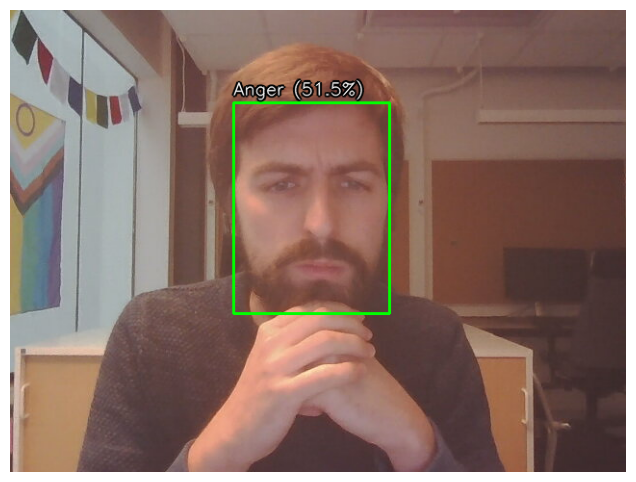

Face bbox: [232,96,394,315]
Emotion: idx=6 (Anger), probs=[0.063 0.003 0.149 0.016 0.047 0.125 0.515 0.083]


In [28]:
# ---- config
image_path = "marc.jpg"
device = "cuda"  # or "cuda:0"
face_model_path = "./weights/Alignment_RetinaFace.pth"
multitask_model_path = "./weights/MTL_backbone.pth"
emo_names = ["Neutral","Happy","Sad","Surprise","Fear","Disgust","Anger","Contempt"]

# ---- init
face_detector = FaceDetector(model_path=face_model_path, device=device)
mtl = MultitaskPredictor(model_path=multitask_model_path, device=device)

# ---- detect
cropped_face, dets = face_detector.get_face(image_path)
if cropped_face is None or dets is None or len(dets) == 0:
    raise SystemExit("No face detected.")

img_bgr = cv2.imread(image_path)
h, w = img_bgr.shape[:2]
x1, y1, x2, y2 = map(int, dets[0][:4])
x1, y1 = max(0, x1), max(0, y1)
x2, y2 = min(w - 1, x2), min(h - 1, y2)

# ---- multitask predict (per docs: returns emotion logits, gaze (yaw,pitch), AU intensities)
emotion_logits, _, _ = mtl.predict(cropped_face)

# emotion
probs = F.softmax(emotion_logits, dim=1)[0].cpu().numpy()
emo_idx = int(np.argmax(probs))
emo_label = f"{emo_names[emo_idx]} ({probs[emo_idx]*100:.1f}%)"

# ---- visualization
vis = img_bgr.copy()
# bbox
cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

# emotion label
cv2.putText(vis, emo_label, (x1, max(0, y1 - 8)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 3, cv2.LINE_AA)
cv2.putText(vis, emo_label, (x1, max(0, y1 - 8)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

# show
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# ---- print raw details
print(f"Face bbox: [{x1},{y1},{x2},{y2}]")
print(f"Emotion: idx={emo_idx} ({emo_names[emo_idx]}), probs={np.round(probs,3)}")

## Exercises

In this block, attempt to join two parts of this Lab - camera access and facial/emotion detection. Write the code that will process live video stream, draw a bounding box around the face with the highest confidence score and write an emotion detected. Is it accurate enough?

### Hint
Openface-test python FaceDetector interface that we use ( https://github.com/CMU-MultiComp-Lab/OpenFace-3.0/tree/main ) reads images from file, so you may need to save frames into a temporary file. Ideally, this class should be modified to read data from memory.

# S2: Train an affect recognition system
Traditional emotion recognition systems often employed a 2 stage pipeline:
* Landmark extraction: from image extract useful landmarks (i.e., what you saw in S1.4)
* Emotion classification: from landmarks detect a single emotion (i.e., what OpenFace implicitly did* in S1.5)

More modern system can skip the landmark extraction phase and give you an emotional label directly.

\* OpenFace actually also uses other extracted features beside pure landmarks, but the point still stands.

## S2.1
Let's begin with the legacy approach. We will use OpenFace to extract landmarks from a set of images, then use those to train an emotion classifier.

In [5]:
from sklearn.model_selection import train_test_split  # for splitting data if needed
from sklearn.svm import SVC  # simple classifier
from sklearn.metrics import accuracy_score, classification_report  # for evaluation
from transformers import AutoImageProcessor, AutoModel  # for dino

# using this to quickly load a random dataset. For the assignment and this lab, you will be provided with a specific dataset.
# NOTE that this your current environment *does not have* this library as it is not required to do the project/assignment
from datasets import load_dataset

In [6]:
device = "cuda"  # or "cpu"

det = FaceDetector("./weights/Alignment_RetinaFace.pth", device=device)
lmk = LandmarkDetector("./weights/Landmark_98.pkl", device=device, device_ids=[0])

# helper function to get landmarks in order to train a landmark->emotion model
def detect_face_and_get_landmarks(image):
    # transform PIL image to BGR numpy array
    img_bgr = cv2.cvtColor(np.array(image.convert("RGB")), cv2.COLOR_RGB2BGR)

    _, dets = det.get_face(img_bgr)
    if dets is None or len(dets) == 0:
        image.save("no_face_detected.png")
        return None

    pts = lmk.detect_landmarks(img_bgr, [dets[0]])[0].astype(np.float32)  # (98,2)
    return pts

Loading pretrained model from ./weights/Alignment_RetinaFace.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300


c:\Users\Daan\Projects\uu-intelligent-interactive-systems-25-26\env\Lib\site-packages\torch\__init__.py:1275: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\tensor\python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)
2025-11-14 15:46:57,605 INFO    : Loaded configure file alignment: 2832f689-0c02-4212-a47d-01b5c3aebec6
2025-11-14 15:46:57,606 INFO    : 
type: alignment
id: 2832f689-0c02-4212-a47d-01b5c3aebec6
note: 
ckpt_dir: /work/jiewenh/openFace/OpenFace-3.0/STAR
image_dir: ./WFLW\WFLW_images
annot_dir: ./
loader_type: alignment
loss_func: STARLoss_v2
batch_size: 32
val_batch_size: 32
test_batch_size: 16
channels: 3
width: 256
height: 256
means: (127.5, 127.5, 127.5)
scale: 0.00784313725490196
display_iteration: 10
milestones: [200, 350, 450]
max_epoch: 500
net: stackedHGnet_v1
nsta

Namespace(config_name='alignment', device_id='cuda:0')


Now, we need an example dataset to train our model. For this lab we will use a random dataset. Note the you don't need to download this dataset as you will be provided with a different one for the lab exercises (and for the assignment).
But, if you want to reproduce the results below, the can be downloaded with: 
```sh
git clone https://huggingface.co/datasets/manojdilz/facial_emotion_detection_dataset
```

In [9]:
dataset = load_dataset("./facial_emotion_detection_dataset")

# unique classes, are already encoded in [0-6]
classes = set(dataset["train"]["label"])
dataset_emo_mapping = ["anger", "disgust", "fear", "happy", "neutral", "sad", "surprise"]  # 0 is anger, 1 is disgust, etc.

# dataset is huge, we will sample 100 images per class
images = []
labels = []
for cls in classes:
    cls_images = dataset["train"].filter(lambda x: x["label"] == cls)
    images.extend(cls_images["image"][:100])
    labels.extend(cls_images["label"][:100])
    
# let's extract landmarks for all images
landmark_features = []
skipped = 0  # sometimes openface does not find a face (even though it's there), let's count how many
skipped_indices = []  # used to filter no face images later
for index, img in enumerate(images):
    pts = detect_face_and_get_landmarks(img)
    if pts is None:
        skipped += 1
        skipped_indices.append(index)
        continue
    feature_vector = pts.flatten()  # shape (196,)
    landmark_features.append(feature_vector)

print(f"Skipped {skipped} images due to no face detected.")

images = [img for i, img in enumerate(images) if i not in skipped_indices]
labels = [lbl for i, lbl in enumerate(labels) if i not in skipped_indices]

# Let's begin training, we will use a simple SVM classifier
svm = SVC()
print(f"Training SVM on {len(landmark_features)} samples...")
svm.fit(landmark_features, labels)
print("SVM training completed.")

# Let's evaluate on the test set
# test using dataset["test"] up to 100 samples per class
test_images = []
test_labels = []
for cls in classes:
    cls_images = dataset["test"].filter(lambda x: x["label"] == cls)
    test_images.extend(cls_images["image"][:100])
    test_labels.extend(cls_images["label"][:100])

test_features = []
skipped_test = 0
skipped_test_indices = []
for index, img in enumerate(test_images):
    pts = detect_face_and_get_landmarks(img)
    if pts is None:
        skipped_test += 1
        skipped_test_indices.append(index)
        continue
    feature_vector = pts.flatten()
    test_features.append(feature_vector)
print(f"Skipped {skipped_test} test images due to no face detected.")
test_images = [img for i, img in enumerate(test_images) if i not in skipped_test_indices]
test_labels = [lbl for i, lbl in enumerate(test_labels) if i not in skipped_test_indices]

print(f"Evaluating SVM on {len(test_features)} samples...")
preds = svm.predict(test_features)  # is an array of numeric labels e.g., [0,1,2,...]
# let's replace numeric labels with string labels for better readability
preds = [dataset_emo_mapping[p] for p in preds]
test_labels_emo = [dataset_emo_mapping[t] for t in test_labels]
acc = accuracy_score(test_labels_emo, preds)
print(f"Test Accuracy: {acc*100:.2f}%")
print("Classification Report:")
print(classification_report(test_labels_emo, preds, target_names=dataset_emo_mapping))

Repo card metadata block was not found. Setting CardData to empty.
2025-11-14 15:58:24,200 WARNING : Repo card metadata block was not found. Setting CardData to empty.


2025-11-14 16:07:48,333 DEBUG   : Attempting to acquire lock 2422863463696 on C:\Users\Daan\.cache\huggingface\datasets\_Users_Daan_.cache_huggingface_datasets_facial_emotion_detection_dataset_default_0.0.0_1b10206bd3d65879.lock
2025-11-14 16:07:48,339 DEBUG   : Lock 2422863463696 acquired on C:\Users\Daan\.cache\huggingface\datasets\_Users_Daan_.cache_huggingface_datasets_facial_emotion_detection_dataset_default_0.0.0_1b10206bd3d65879.lock
2025-11-14 16:07:48,340 DEBUG   : Attempting to release lock 2422863463696 on C:\Users\Daan\.cache\huggingface\datasets\_Users_Daan_.cache_huggingface_datasets_facial_emotion_detection_dataset_default_0.0.0_1b10206bd3d65879.lock
2025-11-14 16:07:48,345 DEBUG   : Lock 2422863463696 released on C:\Users\Daan\.cache\huggingface\datasets\_Users_Daan_.cache_huggingface_datasets_facial_emotion_detection_dataset_default_0.0.0_1b10206bd3d65879.lock
2025-11-14 16:07:49,441 DEBUG   : Attempting to acquire lock 2422851520464 on C:\Users\Daan\.cache\huggingface

Processing face: (68, 32, 215, 222), confidence: 0.9869106411933899


c:\Users\Daan\Projects\uu-intelligent-interactive-systems-25-26\env\Lib\site-packages\torch\functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4319.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Processing face: (20, 12, 196, 219), confidence: 0.9988526105880737
Processing face: (37, 18, 206, 213), confidence: 0.9981708526611328
Processing face: (17, 7, 196, 222), confidence: 0.9979775547981262
Processing face: (36, 13, 204, 231), confidence: 0.9952048063278198
Processing face: (5, -2, 223, 234), confidence: 0.9979485869407654
Processing face: (14, 2, 223, 226), confidence: 0.9926252961158752
Processing face: (34, 9, 206, 231), confidence: 0.9949523210525513
Processing face: (14, 0, 195, 246), confidence: 0.9757779836654663
Processing face: (51, 22, 171, 205), confidence: 0.9993313550949097
Processing face: (25, 4, 195, 219), confidence: 0.996566891670227
Processing face: (34, 16, 202, 219), confidence: 0.9988956451416016
Processing face: (21, 11, 200, 219), confidence: 0.9982994198799133
Processing face: (35, 9, 190, 203), confidence: 0.9960507750511169
Processing face: (26, 17, 198, 222), confidence: 0.9986056685447693
Processing face: (21, 18, 184, 218), confidence: 0.99713

Filter: 100%|██████████| 7178/7178 [00:05<00:00, 1393.25 examples/s]


Processing face: (30, 20, 202, 223), confidence: 0.9980003237724304
Processing face: (19, 2, 201, 219), confidence: 0.9993841648101807
Processing face: (37, 11, 182, 229), confidence: 0.9948782920837402
Processing face: (16, 15, 189, 224), confidence: 0.9946359992027283
Processing face: (24, -4, 203, 224), confidence: 0.9993071556091309
Processing face: (-14, -1, 208, 241), confidence: 0.9942459464073181
Processing face: (26, 14, 194, 223), confidence: 0.9982026815414429
Processing face: (30, 10, 184, 217), confidence: 0.9853436350822449
Processing face: (25, 7, 191, 231), confidence: 0.9974859952926636
Processing face: (19, 4, 177, 204), confidence: 0.9948170781135559
Processing face: (35, 5, 202, 214), confidence: 0.9978256821632385
Processing face: (20, 16, 192, 226), confidence: 0.9987320303916931
Processing face: (11, 0, 179, 207), confidence: 0.9944577217102051
Processing face: (31, 27, 189, 228), confidence: 0.8540740609169006
Processing face: (32, 20, 192, 225), confidence: 0.9

## S2.2: Comparison with OpenFace
How does our super simple model compare to OpenFace's emotion detector? Let's find out.

In [10]:
multitask_model_path = "./weights/MTL_backbone.pth"

emo_names = ["neutral", "happy", "sad", "surprise", "fear", "disgust", "anger", "contempt"]

mtl = MultitaskPredictor(model_path=multitask_model_path, device=device)


def get_image_emotion(image):
    img_bgr = cv2.cvtColor(np.array(image.convert("RGB")), cv2.COLOR_RGB2BGR)
    cropped_face, dets = det.get_face(img_bgr)
    if cropped_face is None or dets is None or len(dets) == 0 or cropped_face.size == 0:
        return None
    emotion_logits, _, _ = mtl.predict(cropped_face)
    probs = F.softmax(emotion_logits, dim=1)[0].cpu().numpy()
    emo_idx = int(np.argmax(probs))
    emo_label = f"{emo_names[emo_idx]}"
    return emo_label


preds = []
for image in test_images:
    emo = get_image_emotion(image)
    if emo is None:
        preds.append("")  # invalid
    else:
        preds.append(emo)

test_labels_emo = [dataset_emo_mapping[t] for t in test_labels]
acc = accuracy_score(test_labels_emo, preds)
print(f"MTL Test Accuracy: {acc*100:.2f}%")
print("MTL Classification Report:")
print(classification_report(test_labels_emo, preds))

c:\Users\Daan\Projects\uu-intelligent-interactive-systems-25-26\env\Lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


Loading multitask model from ./weights/MTL_backbone.pth...
MTL Test Accuracy: 41.91%
MTL Classification Report:
              precision    recall  f1-score   support

                   0.00      0.00      0.00         0
       anger       0.35      0.33      0.34        99
    contempt       0.00      0.00      0.00         0
     disgust       0.63      0.54      0.58       100
        fear       0.21      0.17      0.19        99
       happy       0.63      0.60      0.61        99
     neutral       0.54      0.31      0.40        99
         sad       0.45      0.34      0.38        98
    surprise       0.52      0.64      0.57        98

    accuracy                           0.42       692
   macro avg       0.37      0.33      0.34       692
weighted avg       0.47      0.42      0.44       692



c:\Users\Daan\Projects\uu-intelligent-interactive-systems-25-26\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Daan\Projects\uu-intelligent-interactive-systems-25-26\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Daan\Projects\uu-intelligent-interactive-systems-25-26\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


## S2.3: Get emotions without landmarks

Here, we are going to use DINOv3. We are going to feed it images and we will use its CLS token to extract the emotion.

In [12]:
# This is DINO's smallest model. It is so small it can probably run on a calculator.
pretrained_model_name = "facebook/dinov3-vits16plus-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
model = AutoModel.from_pretrained(pretrained_model_name, device_map="auto", dtype="auto")
model.eval()


@torch.inference_mode()
def extract_cls(images):
    # get the cls token for the images
    feats = []
    for image in images:
        inputs = processor(images=[image], return_tensors="pt")
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        outputs = model(**inputs)
        pooled = outputs.pooler_output.detach().cpu()  # (B, D)
        feats.append(pooled)
    return torch.cat(feats, dim=0)

train_in = extract_cls(images)
svm_dino = SVC()
print(f"Training SVM on DINO features with {train_in.shape[0]} samples...")
svm_dino.fit(train_in.numpy(), labels)
print("SVM training on DINO features completed.")
test_in = extract_cls(test_images)
print(f"Evaluating SVM on DINO features with {test_in.shape[0]} samples...")
preds_dino = svm_dino.predict(test_in.numpy())
acc_dino = accuracy_score(test_labels, preds_dino)
print(f"DINO SVM Test Accuracy: {acc_dino*100:.2f}%")
print("DINO Classification Report:")
print(classification_report(test_labels, preds_dino, target_names=dataset_emo_mapping))

2025-11-14 16:29:08,475 DEBUG   : Resetting dropped connection: huggingface.co
2025-11-14 16:29:08,658 DEBUG   : https://huggingface.co:443 "HEAD /facebook/dinov3-vits16plus-pretrain-lvd1689m/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
2025-11-14 16:29:08,791 DEBUG   : https://huggingface.co:443 "HEAD /facebook/dinov3-vits16plus-pretrain-lvd1689m/resolve/main/processor_config.json HTTP/1.1" 404 0
2025-11-14 16:29:08,951 DEBUG   : https://huggingface.co:443 "HEAD /facebook/dinov3-vits16plus-pretrain-lvd1689m/resolve/main/config.json HTTP/1.1" 200 0
2025-11-14 16:29:11,010 INFO    : We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Training SVM on DINO features with 696 samples...
SVM training on DINO features completed.
Evaluating SVM on DINO features with 692 samples...
DINO SVM Test Accuracy: 51.30%
DINO Classification Report:
              precision    recall  f1-score   support

       anger       0.34      0.42      0.38        99
     disgust       0.63      0.65      0.64       100
        fear       0.38      0.28      0.33        99
       happy       0.78      0.77      0.78        99
     neutral       0.49      0.49      0.49        99
         sad       0.30      0.34      0.32        98
    surprise       0.71      0.63      0.67        98

    accuracy                           0.51       692
   macro avg       0.52      0.51      0.51       692
weighted avg       0.52      0.51      0.51       692



## Exercise
With this notebook, you were provided with the MultiEmoVA dataset. Note that you are **not allowed** to use this dataset outside the scope of this course.

The dataset contains pictures with multiple people in the frame. Use OpenFace's `FaceDetector` to extract the faces, then split your dataset into train and test. Use your train split to train a classifier (using either OpenFace's landmarks or DINO's approach). Finally, evaluate your model with accuracy and a [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

Note that MultiEmoVA does not have emotions as labels, instead it uses valence/arousal (you should already be familiar with the difference from the lectures). 